In [2]:
from collections import Counter
import pathlib
from typing import Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit


warnings.simplefilter('ignore')

In [5]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_ez_df = pd.read_csv(outputs_dir_path.joinpath('train_ez.csv'))
train_ez_df = train_ez_df.dropna(subset=['target'])
display(train_ez_df)

train_not_ez_df = pd.read_csv(outputs_dir_path.joinpath('train_not_ez.csv'))
train_not_ez_df = train_not_ez_df.dropna(subset=['target'])
display(train_not_ez_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
2,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
3,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.000000,7.970333,0,0_0_9
4,10,0,0,10482752.19,-1,1.001374,8839457.10,NaN,NaN,0.999885,18802.00,1.001321,217098.37,1.000000,5.350113,0,0_0_10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642164,192,480,540,67162.62,1,1.000762,11790079.43,1.000834,1.000762,1.000545,168412.86,1.000762,69841.50,1.000698,-1.729727,26454,480_540_192
2642165,193,480,540,6500948.04,1,1.001599,80357531.06,1.002908,1.002326,1.001454,413142.24,1.001599,363532.53,1.001531,-3.880262,26454,480_540_193
2642166,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
2642167,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,1,0,0,166603.91,-1,0.999896,1.642214e+06,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
1,2,0,0,302879.87,-1,0.999561,1.819368e+06,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
2,5,0,0,0.00,0,1.000635,1.355288e+07,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.000000,6.779432,0,0_0_5
3,6,0,0,969969.40,1,1.000115,3.647504e+06,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.000000,-2.499819,0,0_0_6
4,7,0,0,9412959.10,1,0.999818,2.126125e+07,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.000000,-1.959801,0,0_0_7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595718,190,480,540,466320.15,-1,0.999295,3.929472e+07,0.998983,0.999139,0.999295,19725.86,0.999451,169105.20,0.999311,-0.470281,26454,480_540_190
2595719,191,480,540,36937785.44,1,0.995983,6.083261e+08,0.999086,0.997746,0.995913,84744.00,0.995983,48025.00,0.995958,0.799894,26454,480_540_191
2595720,194,480,540,262271.52,-1,1.001504,3.922295e+06,1.000677,1.000677,1.001504,20829.20,1.001917,139637.49,1.001557,4.839897,26454,480_540_194
2595721,197,480,540,0.00,0,0.995789,1.272544e+07,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

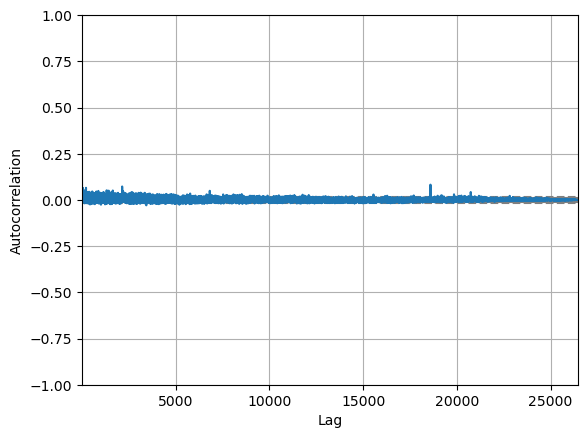

In [30]:
autocorrelation_plot(train_not_ez_df.query('stock_id==7')['ask_size'])

In [36]:
time = np.arange(0, 26454, 1)
time1 = time[:22045]
time2 = time[22045:]
print(time1)
print(time2)

[    0     1     2 ... 22042 22043 22044]
[22045 22046 22047 ... 26451 26452 26453]


In [40]:
display(train_ez_df.query('time_id in @time1')['date_id'])
display(train_ez_df.query('time_id in @time2')['date_id'])

0            0
1            0
2            0
3            0
4            0
          ... 
2201164    400
2201165    400
2201166    400
2201167    400
2201168    400
Name: date_id, Length: 2201169, dtype: int64

2201169    400
2201170    400
2201171    400
2201172    400
2201173    400
          ... 
2642064    480
2642065    480
2642066    480
2642067    480
2642068    480
Name: date_id, Length: 440900, dtype: int64

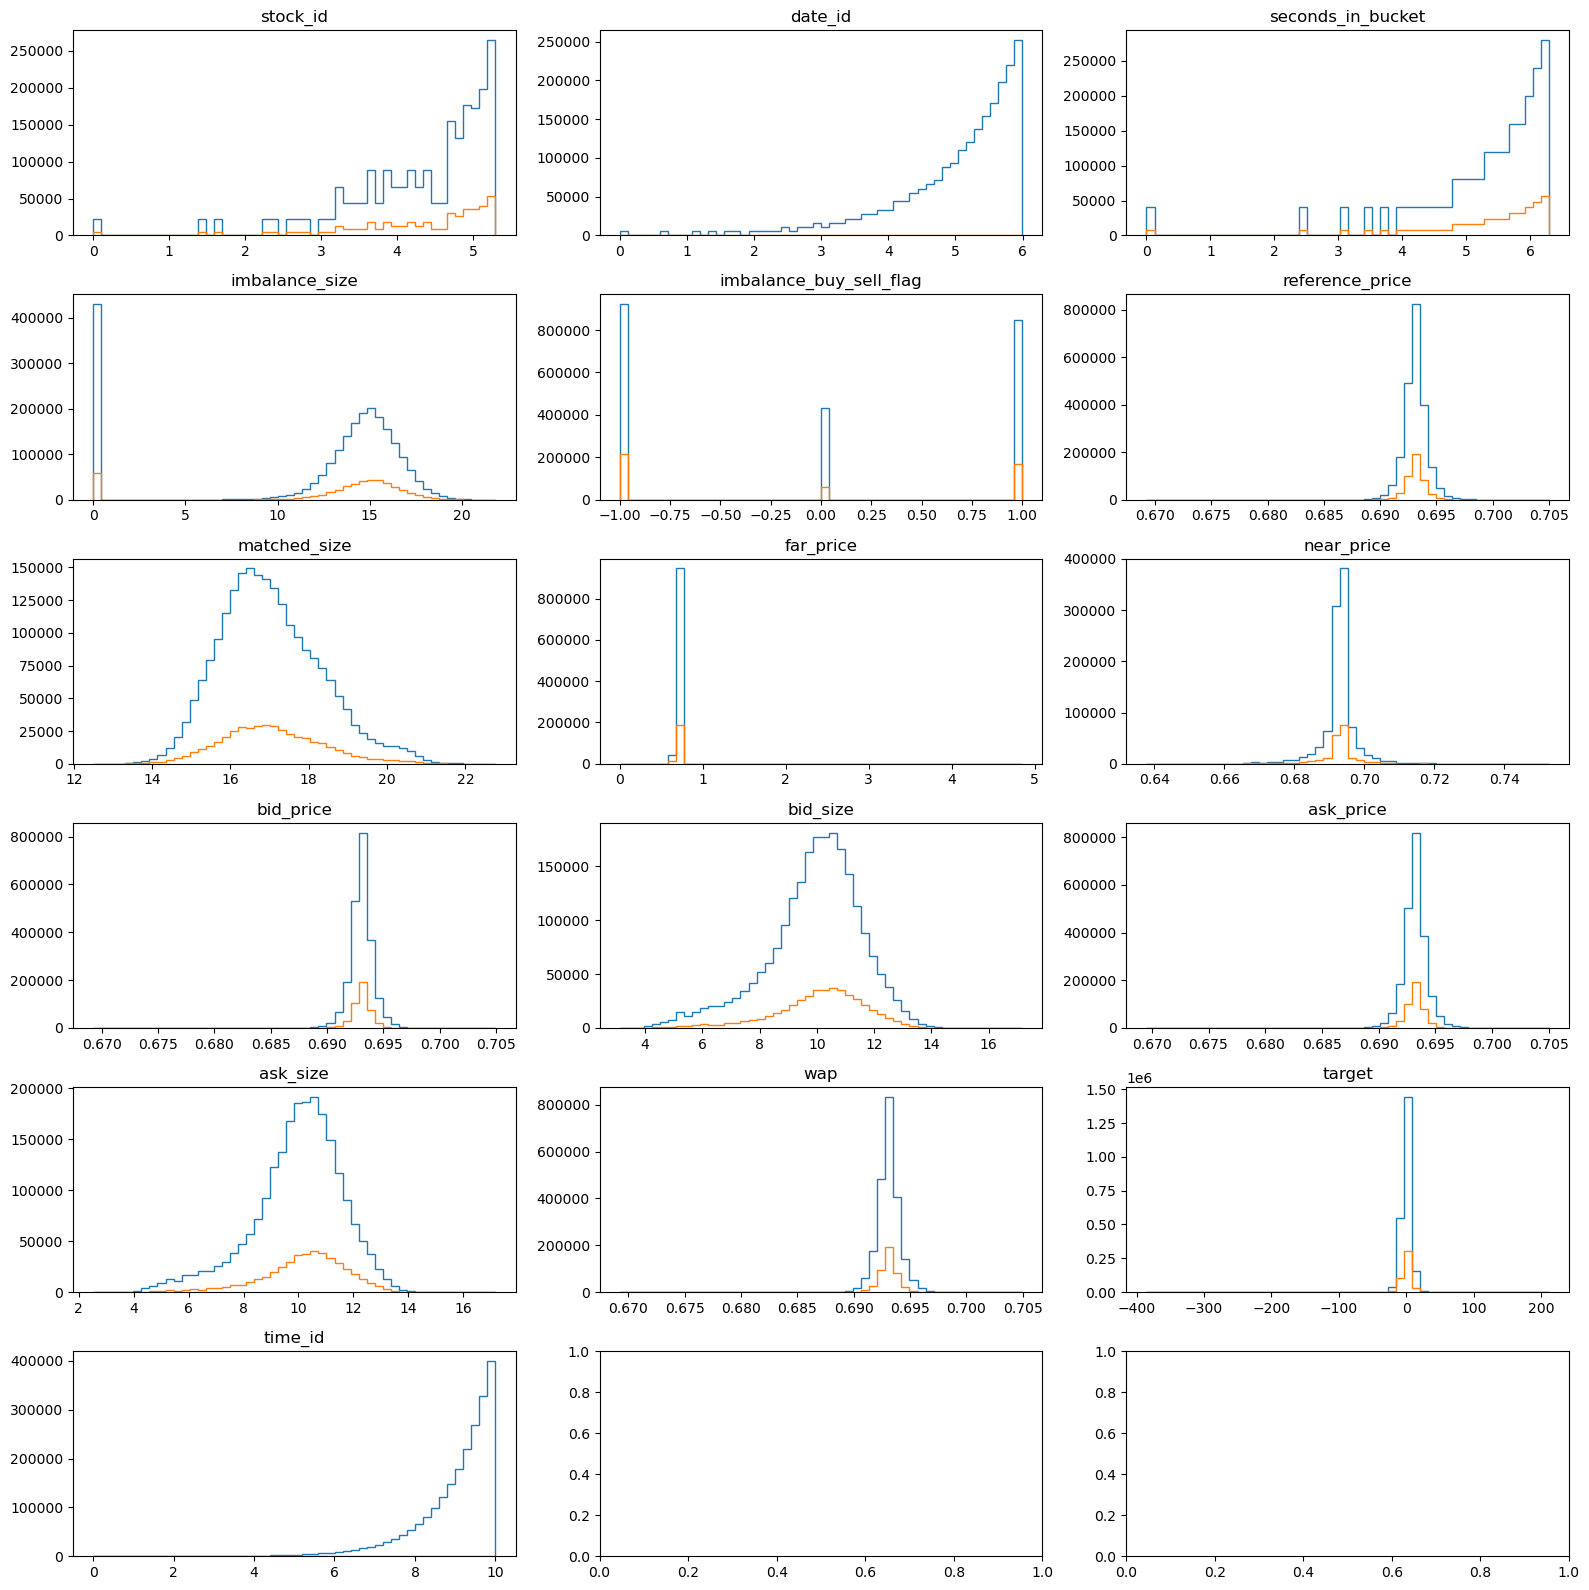

In [38]:
nrows = len(train_ez_df.columns) // 3 if len(train_ez_df.columns) % 3 == 0 else len(train_ez_df.columns) // 3 + 1
_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i, col in enumerate(train_ez_df.columns):
    if col != 'row_id':
        if train_ez_df[col].min() < 0:
            _, bins, _ = axs[i//3, i%3].hist(train_ez_df.query('time_id in @time1')[col], bins=50, histtype='step')
            axs[i//3, i%3].hist(train_ez_df.query('time_id in @time2')[col], bins=bins, histtype='step')
        else:
            _, bins, _ = axs[i//3, i%3].hist(np.log1p(train_ez_df.query('time_id in @time1')[col]), bins=50, histtype='step')
            axs[i//3, i%3].hist(np.log1p(train_ez_df.query('time_id in @time2')[col]), bins=bins, histtype='step')
        axs[i//3, i%3].set_title(col)
plt.tight_layout()

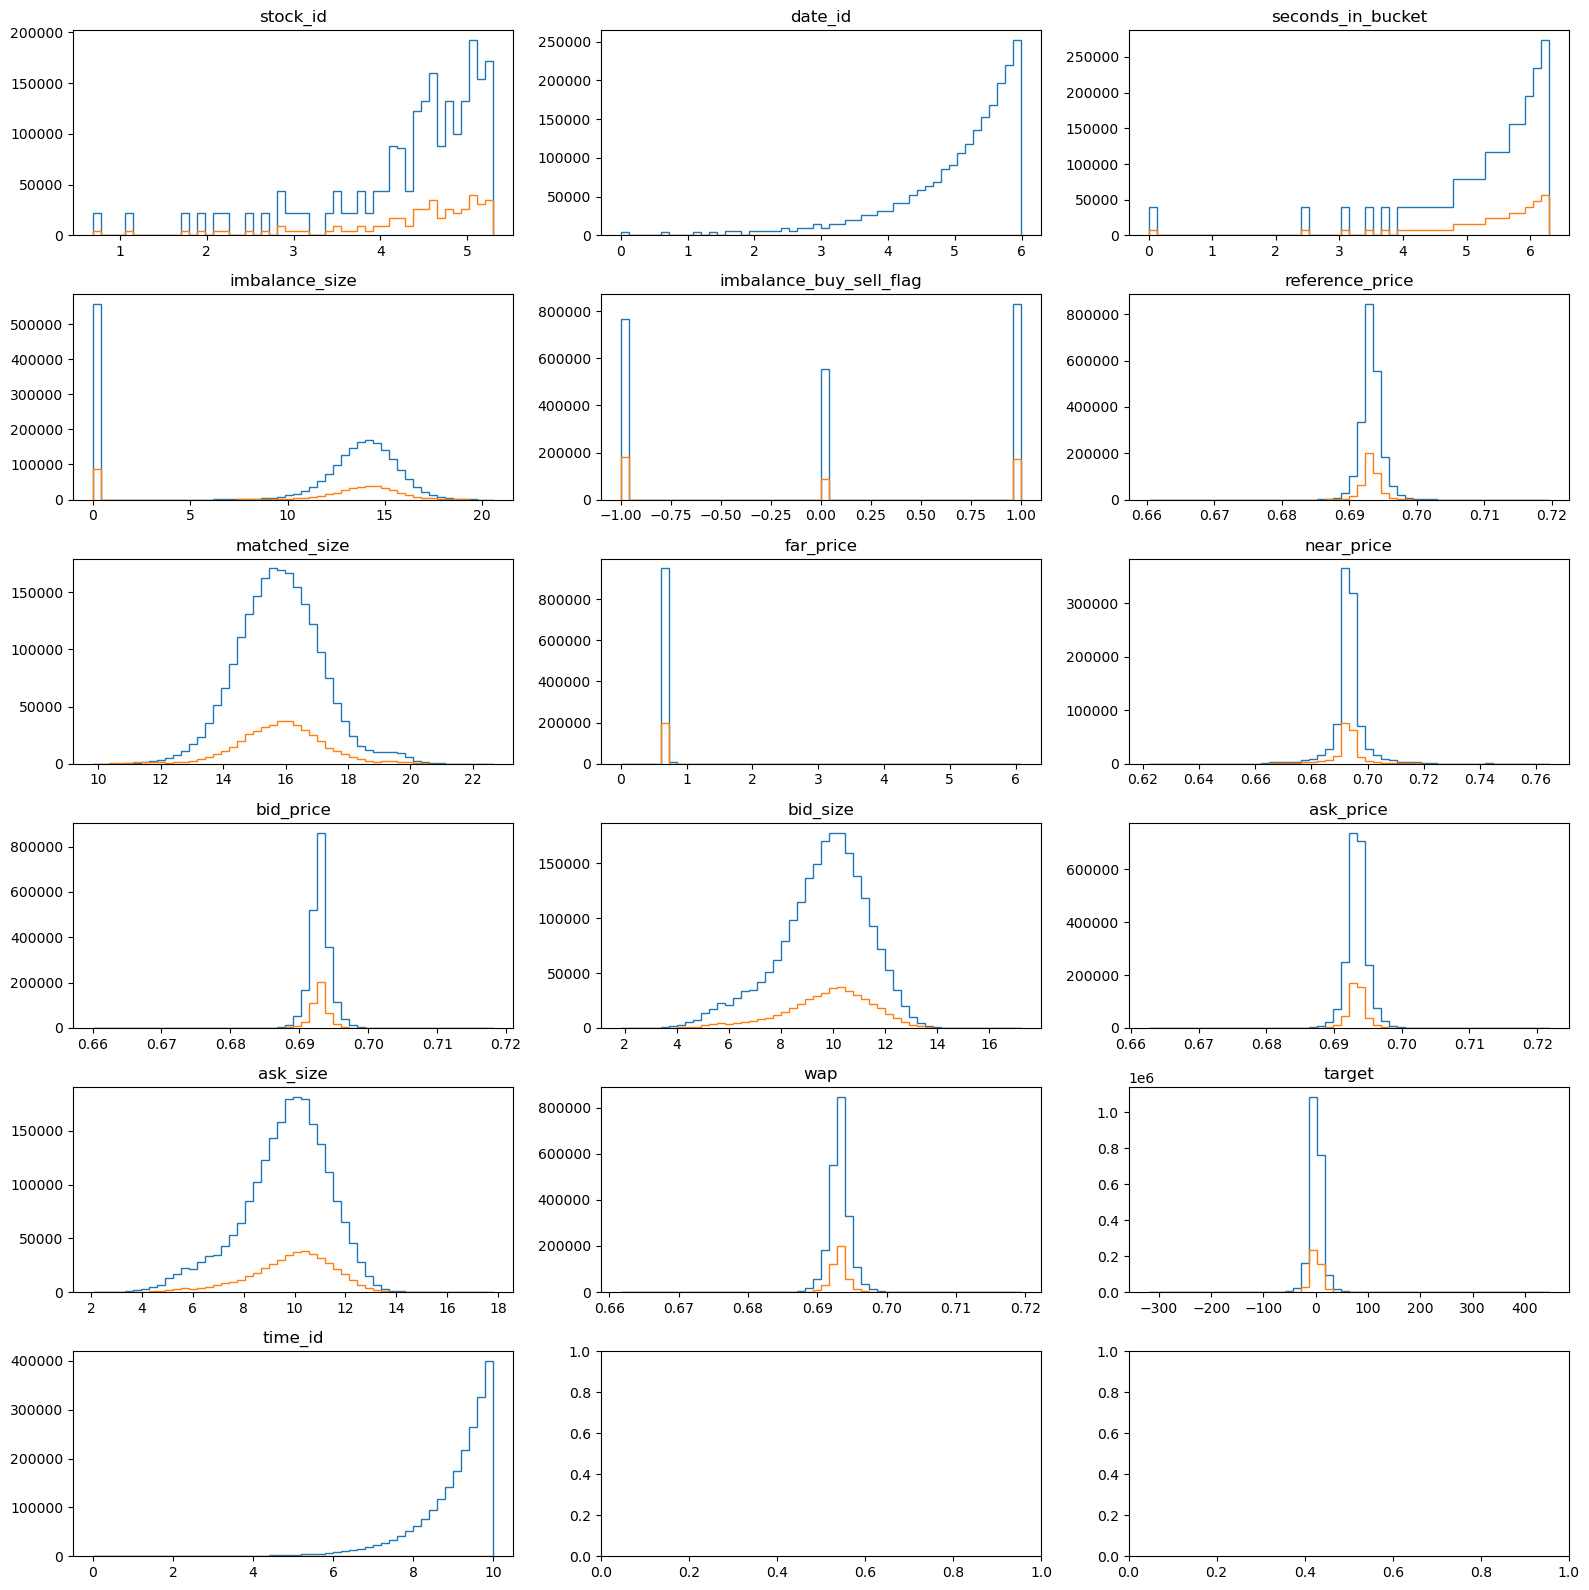

In [41]:
nrows = len(train_not_ez_df.columns) // 3 if len(train_not_ez_df.columns) % 3 == 0 else len(train_not_ez_df.columns) // 3 + 1
_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i, col in enumerate(train_not_ez_df.columns):
    if col != 'row_id':
        if train_not_ez_df[col].min() < 0:
            _, bins, _ = axs[i//3, i%3].hist(train_not_ez_df.query('time_id in @time1')[col], bins=50, histtype='step')
            axs[i//3, i%3].hist(train_not_ez_df.query('time_id in @time2')[col], bins=bins, histtype='step')
        else:
            _, bins, _ = axs[i//3, i%3].hist(np.log1p(train_not_ez_df.query('time_id in @time1')[col]), bins=50, histtype='step')
            axs[i//3, i%3].hist(np.log1p(train_not_ez_df.query('time_id in @time2')[col]), bins=bins, histtype='step')
        axs[i//3, i%3].set_title(col)
plt.tight_layout()